# Predicting Stock Price of Tesla

Our objective is to predict 10th day stock price given 9 previous days stock prices. 

The following sequence of code will prepare our data for analysis.

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(1)

## Collect and prepare data for analysis

In [232]:
df = pd.read_csv('C:/Users/prath/Downloads/TSLA.csv',  parse_dates=True)

In [233]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [234]:
df = df[['Close']] #the target column

In [235]:
df

,Close
0,325.733337
1,336.260010
2,335.016663
3,332.673340
4,292.140015
...,...
247,185.000000
248,187.039993
249,184.309998
250,180.589996


In [236]:
df['Close'].isna().sum()

0

In [237]:
row_count = df.shape[0] # store the number of observations
row_count

252

In [238]:
stocks = df.to_numpy() # to make things easier, we create a numpy array from our dataframe of stock prices
stocks.shape

(252, 1)

In [239]:
sequence_length = 10  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [240]:
stocks = stocks[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
stocks.shape

(250, 1)

In [241]:
stocks = stocks.reshape(row_count // sequence_length, sequence_length) # note that stock prices are a multiple of sequence length, we can split the data into rows of sequence length.
stocks

array([[335.016663, 332.67334 , 292.140015, 293.83667 , 292.503326,
        290.253326, 300.980011, 303.083344, 317.540009, 291.093323],
       [288.549988, 262.369995, 266.679993, 244.666672, 242.666672,
        256.529999, 241.456665, 253.869995, 236.603333, 236.473328],
       [221.300003, 224.96666 , 209.386673, 219.600006, 235.910004,
        253.210007, 252.753326, 246.789993, 258.333344, 234.516663],
       [238.279999, 238.886673, 241.866669, 239.706665, 232.229996,
        215.736664, 220.889999, 233.      , 213.100006, 216.759995],
       [237.036667, 236.08667 , 235.070007, 245.706665, 244.919998,
        232.66333 , 228.490005, 224.473328, 227.263336, 233.066666],
       [231.733337, 244.543335, 250.763336, 234.343338, 233.070007,
        237.039993, 238.313339, 240.066666, 240.546661, 245.529999],
       [247.5     , 271.706665, 272.243347, 268.433319, 258.859985,
        274.820007, 280.899994, 297.149994, 297.276672, 300.58667 ],
       [307.396667, 308.633331, 288.17001

In [242]:
# create our X and y. 
# X will be the 9 days prior...
X = stocks[:, :-1] # all rows, all columns except the last one
# y will be the 10th day (what we are trying to predict)
y = stocks[:, -1] # all rows, only the last column

In [243]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [244]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(17, 9, 1)
(8, 9, 1)


**Single RNN**

In [245]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(64, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_16 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [246]:
# Using MSE as loss function and metric as this is a regression problem
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [247]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
1/1 [==============================] - 1s 1s/step - loss: 55880.0781 - root_mean_squared_error: 236.3897 - val_loss: 37962.6875 - val_root_mean_squared_error: 194.8402
Epoch 2/600
1/1 [==============================] - 0s 32ms/step - loss: 55854.4414 - root_mean_squared_error: 236.3354 - val_loss: 37940.5508 - val_root_mean_squared_error: 194.7833
Epoch 3/600
1/1 [==============================] - 0s 26ms/step - loss: 55827.3359 - root_mean_squared_error: 236.2781 - val_loss: 37913.7109 - val_root_mean_squared_error: 194.7144
Epoch 4/600
1/1 [==============================] - 0s 26ms/step - loss: 55793.4688 - root_mean_squared_error: 236.2064 - val_loss: 37880.3281 - val_root_mean_squared_error: 194.6287
Epoch 5/600
1/1 [==============================] - 0s 32ms/step - loss: 55750.0156 - root_mean_squared_error: 236.1144 - val_loss: 37840.7734 - val_root_mean_squared_error: 194.5271
Epoch 6/600
1/1 [==============================] - 0s 37ms/step - loss: 55698.8398 - root_me

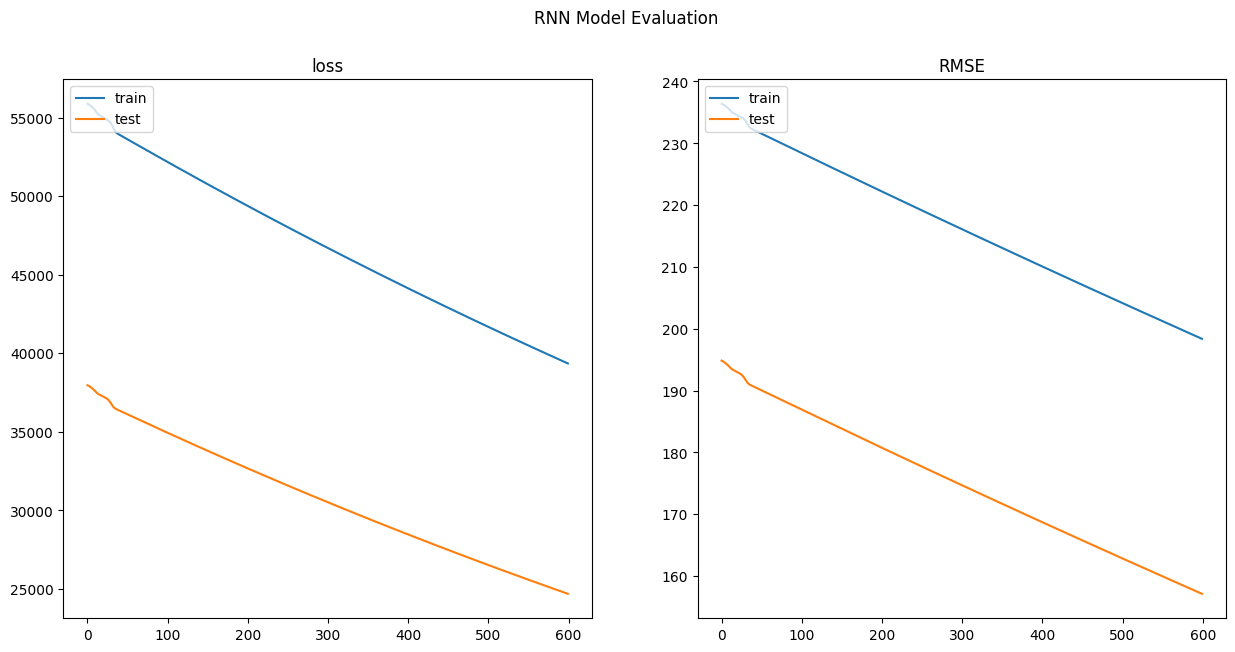

In [248]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [249]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  

mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 0s 98ms/step


157.1273476959146

**Deep RNN**

In [250]:
n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(64, return_sequences=True, input_shape=[n_steps, n_inputs]),
        SimpleRNN(16, return_sequences=True),
        SimpleRNN(32, return_sequences=False),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_17 (SimpleRNN)   (None, 9, 64)             4224      
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 9, 16)             1296      
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 32)                1568      
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,121
Trainable params: 7,121
Non-trainable params: 0
_________________________________________________________________


In [251]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [252]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
1/1 [==============================] - 3s 3s/step - loss: 55834.5430 - root_mean_squared_error: 236.2933 - val_loss: 37843.2422 - val_root_mean_squared_error: 194.5334
Epoch 2/600
1/1 [==============================] - 0s 32ms/step - loss: 55708.3477 - root_mean_squared_error: 236.0262 - val_loss: 37743.6016 - val_root_mean_squared_error: 194.2771
Epoch 3/600
1/1 [==============================] - 0s 32ms/step - loss: 55588.4062 - root_mean_squared_error: 235.7719 - val_loss: 37643.1094 - val_root_mean_squared_error: 194.0183
Epoch 4/600
1/1 [==============================] - 0s 40ms/step - loss: 55466.7539 - root_mean_squared_error: 235.5138 - val_loss: 37549.4141 - val_root_mean_squared_error: 193.7767
Epoch 5/600
1/1 [==============================] - 0s 33ms/step - loss: 55352.2188 - root_mean_squared_error: 235.2705 - val_loss: 37466.4297 - val_root_mean_squared_error: 193.5625
Epoch 6/600
1/1 [==============================] - 0s 40ms/step - loss: 55250.3359 - root_me

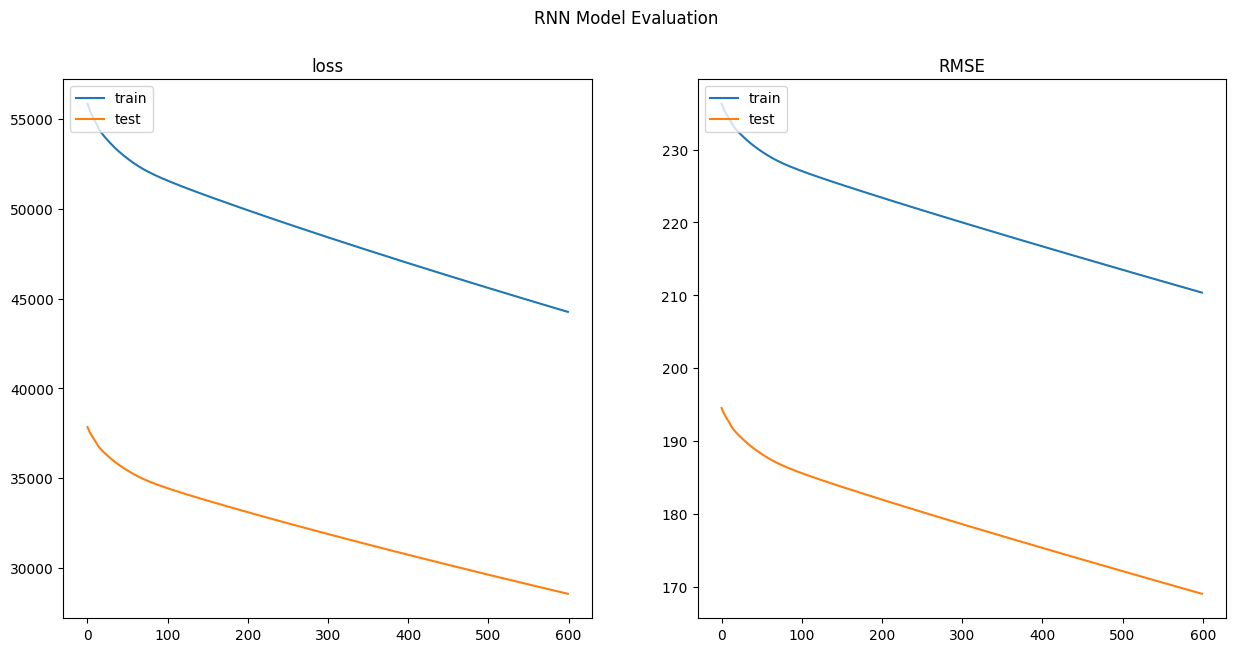

In [253]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [254]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  

mean_squared_error(y_test, y_pred)**0.5

1/1 [==============================] - 0s 227ms/step


169.02862248741494

**LSTM with one layer**

In [255]:
n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        LSTM(64, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 64)                16896     
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [256]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [257]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
1/1 [==============================] - 3s 3s/step - loss: 55259.3438 - root_mean_squared_error: 235.0731 - val_loss: 37464.3906 - val_root_mean_squared_error: 193.5572
Epoch 2/600
1/1 [==============================] - 0s 40ms/step - loss: 55234.3672 - root_mean_squared_error: 235.0199 - val_loss: 37450.1641 - val_root_mean_squared_error: 193.5204
Epoch 3/600
1/1 [==============================] - 0s 32ms/step - loss: 55216.8438 - root_mean_squared_error: 234.9827 - val_loss: 37434.9258 - val_root_mean_squared_error: 193.4811
Epoch 4/600
1/1 [==============================] - 0s 32ms/step - loss: 55197.8242 - root_mean_squared_error: 234.9422 - val_loss: 37418.5391 - val_root_mean_squared_error: 193.4387
Epoch 5/600
1/1 [==============================] - 0s 41ms/step - loss: 55177.1992 - root_mean_squared_error: 234.8983 - val_loss: 37401.0391 - val_root_mean_squared_error: 193.3935
Epoch 6/600
1/1 [==============================] - 0s 41ms/step - loss: 55155.1289 - root_me

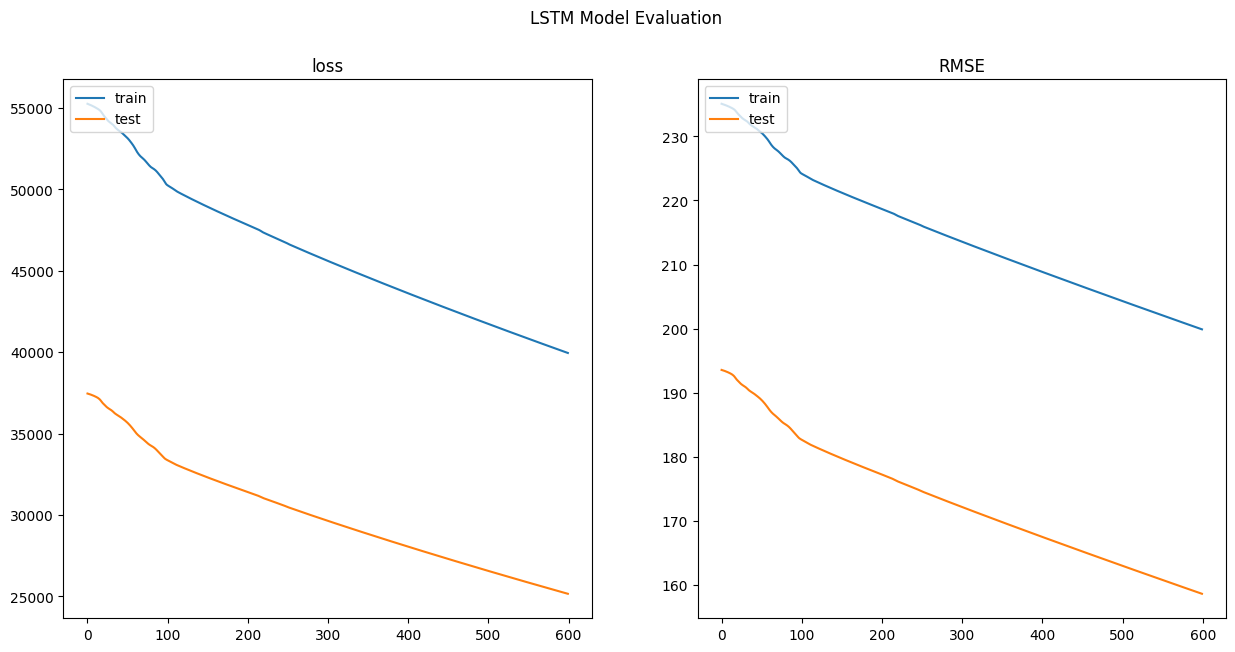

In [258]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('LSTM Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [259]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  
mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 0s 280ms/step


158.6414052936264

**LSTM with more layers**

In [260]:
n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        LSTM(64,return_sequences=True, input_shape=[n_steps, n_inputs]),
        LSTM(32, return_sequences=True),
        LSTM(32,return_sequences=False),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 9, 64)             16896     
                                                                 
 lstm_28 (LSTM)              (None, 9, 32)             12416     
                                                                 
 lstm_29 (LSTM)              (None, 32)                8320      
                                                                 
 dense_32 (Dense)            (None, 1)                 33        
                                                                 
Total params: 37,665
Trainable params: 37,665
Non-trainable params: 0
_________________________________________________________________


In [261]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [262]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
1/1 [==============================] - 5s 5s/step - loss: 55471.4844 - root_mean_squared_error: 235.5238 - val_loss: 37620.9453 - val_root_mean_squared_error: 193.9612
Epoch 2/600
1/1 [==============================] - 0s 49ms/step - loss: 55437.2695 - root_mean_squared_error: 235.4512 - val_loss: 37592.1094 - val_root_mean_squared_error: 193.8868
Epoch 3/600
1/1 [==============================] - 0s 42ms/step - loss: 55402.3789 - root_mean_squared_error: 235.3771 - val_loss: 37560.1719 - val_root_mean_squared_error: 193.8045
Epoch 4/600
1/1 [==============================] - 0s 40ms/step - loss: 55363.6719 - root_mean_squared_error: 235.2949 - val_loss: 37524.7188 - val_root_mean_squared_error: 193.7130
Epoch 5/600
1/1 [==============================] - 0s 40ms/step - loss: 55320.6211 - root_mean_squared_error: 235.2034 - val_loss: 37485.3203 - val_root_mean_squared_error: 193.6113
Epoch 6/600
1/1 [==============================] - 0s 40ms/step - loss: 55272.7188 - root_me

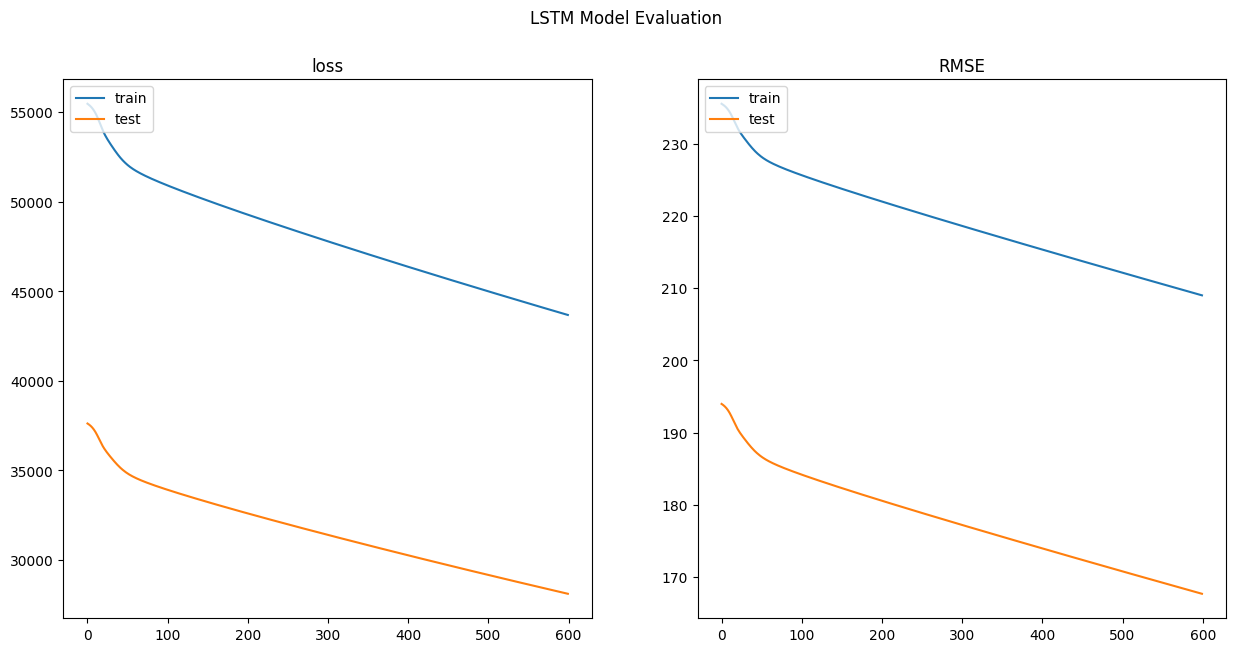

In [263]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('LSTM Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [264]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  

mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 1s 857ms/step


167.67113606340672

**GRU with one layer**

In [265]:
n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        GRU(64, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 64)                12864     
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [266]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [267]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
1/1 [==============================] - 2s 2s/step - loss: 55773.6445 - root_mean_squared_error: 236.1644 - val_loss: 37837.3438 - val_root_mean_squared_error: 194.5182
Epoch 2/600
1/1 [==============================] - 0s 40ms/step - loss: 55726.7500 - root_mean_squared_error: 236.0651 - val_loss: 37805.5938 - val_root_mean_squared_error: 194.4366
Epoch 3/600
1/1 [==============================] - 0s 32ms/step - loss: 55691.3125 - root_mean_squared_error: 235.9901 - val_loss: 37770.0742 - val_root_mean_squared_error: 194.3452
Epoch 4/600
1/1 [==============================] - 0s 40ms/step - loss: 55651.4336 - root_mean_squared_error: 235.9056 - val_loss: 37729.2812 - val_root_mean_squared_error: 194.2403
Epoch 5/600
1/1 [==============================] - 0s 32ms/step - loss: 55604.7266 - root_mean_squared_error: 235.8065 - val_loss: 37681.6953 - val_root_mean_squared_error: 194.1177
Epoch 6/600
1/1 [==============================] - 0s 32ms/step - loss: 55548.1016 - root_me

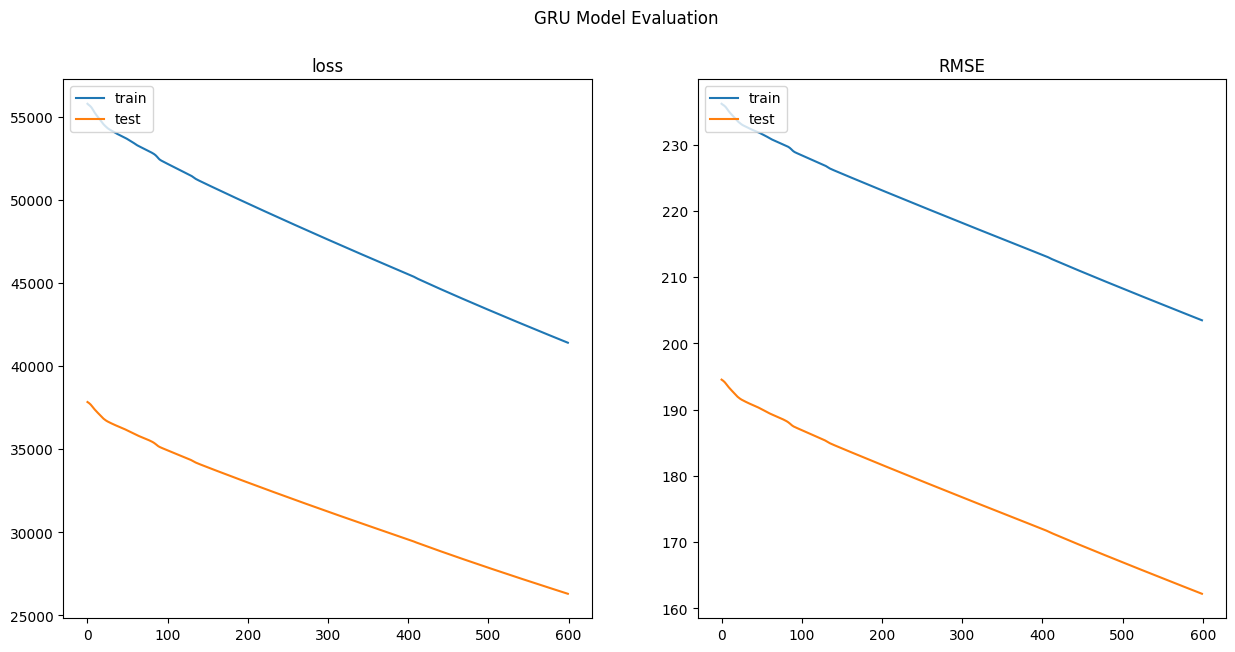

In [268]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('GRU Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [269]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  

mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 0s 253ms/step


162.18930937403005

**GRU with more layers**

In [270]:
n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        GRU(64,return_sequences=True, input_shape=[n_steps, n_inputs]),
        GRU(32, return_sequences=True),
        GRU(16,return_sequences=False),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_17 (GRU)                (None, 9, 64)             12864     
                                                                 
 gru_18 (GRU)                (None, 9, 32)             9408      
                                                                 
 gru_19 (GRU)                (None, 16)                2400      
                                                                 
 dense_34 (Dense)            (None, 1)                 17        
                                                                 
Total params: 24,689
Trainable params: 24,689
Non-trainable params: 0
_________________________________________________________________


In [271]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [272]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
1/1 [==============================] - 5s 5s/step - loss: 55402.2734 - root_mean_squared_error: 235.3769 - val_loss: 37502.5000 - val_root_mean_squared_error: 193.6556
Epoch 2/600
1/1 [==============================] - 0s 48ms/step - loss: 55286.5156 - root_mean_squared_error: 235.1308 - val_loss: 37409.9258 - val_root_mean_squared_error: 193.4165
Epoch 3/600
1/1 [==============================] - 0s 38ms/step - loss: 55175.4062 - root_mean_squared_error: 234.8945 - val_loss: 37312.6484 - val_root_mean_squared_error: 193.1648
Epoch 4/600
1/1 [==============================] - 0s 40ms/step - loss: 55058.5938 - root_mean_squared_error: 234.6457 - val_loss: 37210.8828 - val_root_mean_squared_error: 192.9012
Epoch 5/600
1/1 [==============================] - 0s 40ms/step - loss: 54936.2344 - root_mean_squared_error: 234.3848 - val_loss: 37104.7578 - val_root_mean_squared_error: 192.6259
Epoch 6/600
1/1 [==============================] - 0s 40ms/step - loss: 54808.5508 - root_me

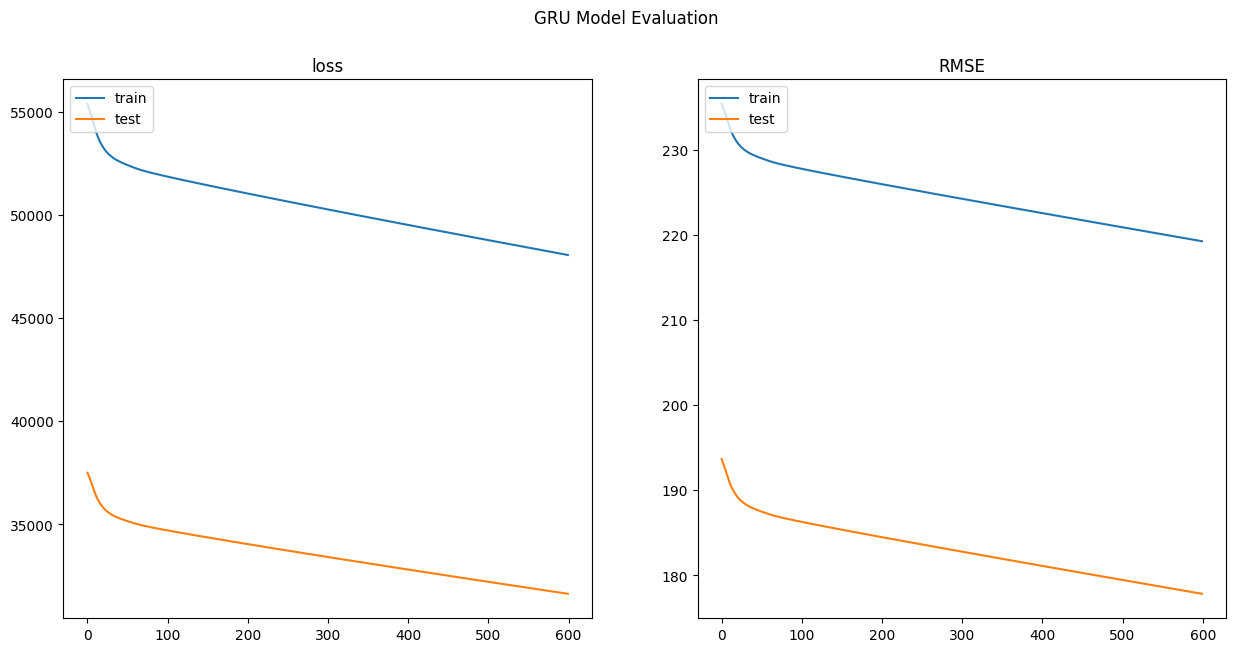

In [273]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('GRU Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [274]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test) 

mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 1s 1s/step


177.84521837026023

**Conv1D**

In [275]:
n_steps = sequence_length-1
n_inputs = 1

model = Sequential([
    Conv1D(filters=10, kernel_size=3, strides=1, padding="valid", input_shape=[n_steps, n_inputs]),
    Conv1D(filters=20, kernel_size=3, strides=1, padding="valid"),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(1, activation=None)
])

model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 7, 10)             40        
                                                                 
 conv1d_11 (Conv1D)          (None, 5, 20)             620       
                                                                 
 lstm_30 (LSTM)              (None, 5, 32)             6784      
                                                                 
 lstm_31 (LSTM)              (None, 32)                8320      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 15,797
Trainable params: 15,797
Non-trainable params: 0
_________________________________________________________________


In [276]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [277]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
1/1 [==============================] - 4s 4s/step - loss: 55460.5039 - root_mean_squared_error: 235.5005 - val_loss: 37587.6172 - val_root_mean_squared_error: 193.8753
Epoch 2/600
1/1 [==============================] - 0s 36ms/step - loss: 55408.5703 - root_mean_squared_error: 235.3902 - val_loss: 37540.9609 - val_root_mean_squared_error: 193.7549
Epoch 3/600
1/1 [==============================] - 0s 35ms/step - loss: 55332.8281 - root_mean_squared_error: 235.2293 - val_loss: 37504.8398 - val_root_mean_squared_error: 193.6617
Epoch 4/600
1/1 [==============================] - 0s 40ms/step - loss: 55285.5312 - root_mean_squared_error: 235.1288 - val_loss: 37469.8281 - val_root_mean_squared_error: 193.5712
Epoch 5/600
1/1 [==============================] - 0s 40ms/step - loss: 55250.3086 - root_mean_squared_error: 235.0538 - val_loss: 37440.8438 - val_root_mean_squared_error: 193.4964
Epoch 6/600
1/1 [==============================] - 0s 38ms/step - loss: 55216.8086 - root_me

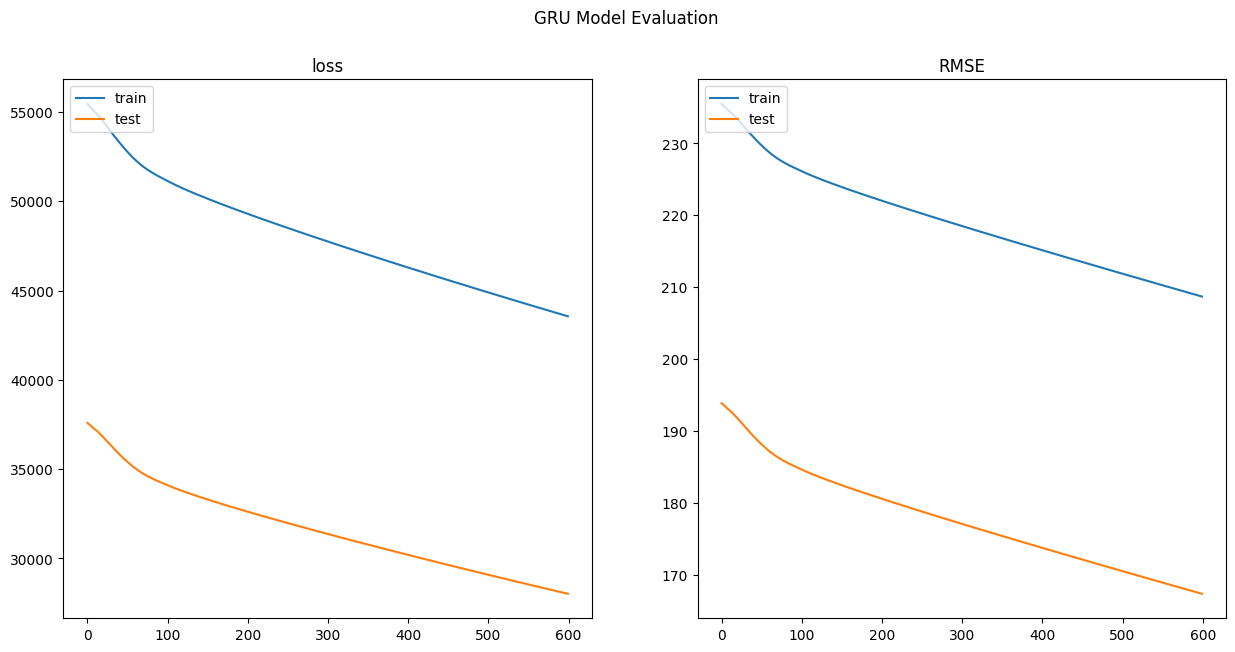

In [278]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('GRU Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [279]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test) 

mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 1s 543ms/step


167.37706991596798

Simple RNN-           157.1273476959146                                                                              
LSTM-  	  	          158.6414052936264                                                                              
GRU with one layer-   162.18930937403005                                                                             
Conv1D-              167.37706991596798                                                                             
LSTM with more layers-167.67113606340672                                                                             
Deep RNN-     	      169.02862248741494                                                                             
GRU with more layers- 177.84521837026023

Here the metric we have considered to evaluate the best model is Root Mean Squared Error. It is a value ranging from 0 to infinity. Usually the lesser the RMSE,the better the model performed.Looking at the above values it is evident that Simple RNN has performed better followed by LSTM with one layer and GRU with one layer.